# Early Exaggeration Length

## Setup 

In [102]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from openTSNE import TSNE
import time
import json
from math import ceil

# for local imports  
from pathlib import Path
import sys
import os 

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

figures_dir = Path.cwd().parent / "figures"
sys.path.append(str(figures_dir))

results_dir = Path.cwd().parent / "results"
sys.path.append(str(results_dir))

import datasets
import quality_measures

## Functions 

### KLD Monitor

In [103]:
from openTSNE import callbacks

class KLDMonitor(callbacks.Callback):
    def __init__(self, ee_iter, record_every=5):
        self.record_every = record_every
        self.kl_divergences = {}
        self.ee_iter = ee_iter
    
    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence while ensuring unique iteration values.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            # in this case we are in the embedding phase  
            if iteration in self.kl_divergences or iteration > self.ee_iter:
                self.kl_divergences[iteration + self.ee_iter] = error 
            # in the EE phase     
            else: 
                self.kl_divergences[iteration] = error

### Running t-SNE

In [ ]:
def run_tsne_with_callbacks_and_timing(datasets, ee_lengths, verbose=False, filename="ee_length_times.json"):
    """Returns embedding dictionary with keys given by perplexity and dataset used to generate the embedding.
    
    Also tracks and saves the time taken for each embedding run to a JSON file.
    
    Parameters:
    - datasets: list of tuples (data, labels)
    - ee_lengths: list of ee lengths for t-SNE
    - verbose (bool): If True, prints additional TSNE information.
    - save_times_path (str): File path to automatically save the time tracking data.
    
    Returns:
    - embedding_dict: dictionary with keys (perp, dataset_index) mapping to (embedding, labels, kld_values)
    """
    embedding_dict = {}
    timings = []  # List to store timing information for each embedding

    save_times_path = os.path.join(results_dir, filename)

    for ee_iter in tqdm(ee_lengths):
        for i, dataset in enumerate(datasets):
            data, labels = dataset
            # Convert to np.array if data is a DataFrame
            if hasattr(data, "values"):
                data = data.values.astype(float)

            kld_monitor = KLDMonitor(ee_iter)
            
            tsne = TSNE(early_exaggeration_iter=ee_iter, n_iter=750 - ee_iter, n_jobs=-1,
                        callbacks=kld_monitor, callbacks_every_iters=5,
                        random_state=42, verbose=verbose)
            # print(f"running {ee_iter} EE iteration and {750-ee_iter} normal ones")
            
            start_time = time.time()
            embedding = tsne.fit(data)
            elapsed_time = time.time() - start_time
            
            kld_values = kld_monitor.kl_divergences
            embedding_dict[(ee_iter, i)] = (embedding, labels, kld_values)
            
            # Record timing data for this embedding
            timings.append({
                "ee_length": ee_iter,
                "dataset_index": i,
                "time_taken_seconds": elapsed_time
            })

    # Automatically save the timing information to the specified JSON file.
    with open(save_times_path, "w") as f:
        json.dump(timings, f, indent=4)
    
    return embedding_dict

In [ ]:
def run_tsne_with_seeds(dataset, ee_lengths, seeds, verbose=False):
    """Returns embedding dictionary with keys given by perplexity and dataset used to generate the embedding.
    
    Also tracks and saves the time taken for each embedding run to a JSON file.
    
    Parameters:
    - dataset: one dataset, tuple (data, labels)
    - ee_lengths: list of ee lengths for t-SNE
    - seeds: a list of seeds 
    - verbose (bool): If True, prints additional TSNE information.
    
    Returns:
    - embedding_dict: dictionary with keys (perp, dataset_index) mapping to (embedding, labels, kld_values)
    """
    embedding_dict = {}

    for ee_iter in tqdm(ee_lengths):
        for seed in seeds:
            data, labels = dataset
            # Convert to np.array if data is a DataFrame
            if hasattr(data, "values"):
                data = data.values.astype(float)

            kld_monitor = KLDMonitor(ee_iter)
            
            tsne = TSNE(early_exaggeration_iter=ee_iter, n_iter=750 - ee_iter, n_jobs=-1,
                        callbacks=kld_monitor, callbacks_every_iters=5,
                        random_state=seed, verbose=verbose)
            # print(f"running {ee_iter} EE iteration and {750-ee_iter} normal ones")
            
            start_time = time.time()
            embedding = tsne.fit(data)
            elapsed_time = time.time() - start_time
            
            kld_values = kld_monitor.kl_divergences
            embedding_dict[(ee_iter, seed)] = (embedding, labels, kld_values)
            
    return embedding_dict

### Embedding Grid Plotting

In [144]:
def plot_embedding_grid(embeddings, row_parameter, column_parameter, row_string="", column_string="", cmap="tab20", file_start="ee_length", emph_first_row=True):
    """
    Plots a grid of t-SNE embeddings with a common column label.

    Parameters:
    - embeddings (dict): Keys are (col_value, row_value) tuples, and values are (embedding_array, labels, kld_values).
    - row_parameter (list): Values for rows (e.g., datasets [0, 1, 2, 3]).
    - column_parameter (list): Values for columns (e.g., number of iterations, perplexity, etc.).
    - row_string (str): Label for the row axis.
    - column_string (str): Common label for the column axis (displayed once over the grid).
    - cmap: "tab20" by default 
    - file_start: e.g. "eta"
    """
    num_rows = len(row_parameter)
    num_cols = len(column_parameter)
    
    subplot_size = 3  
    fig, axes = plt.subplots(num_rows, num_cols, 
                             figsize=(12, subplot_size * num_rows), # (num_cols * subplot_size, num_rows * subplot_size), 
                             squeeze=False)
    
    # Add a common column label above the grid 
    fig.suptitle(column_string, fontsize=12)

    # Plot embeddings in each subplot
    for row_idx, row_value in enumerate(row_parameter):
        for col_idx, col_value in enumerate(column_parameter):
            ax = axes[row_idx, col_idx]
            
            # Unpack; kld_values is ignored here.
            embedding, labels, _ = embeddings[(col_value, row_value)]

            # plot scatterplot 
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=7 if row_idx==0 and emph_first_row else 2, alpha=1.0 if row_idx==0 and emph_first_row else 0.6)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Remove axis outlines
            for spine in ax.spines.values():
                spine.set_visible(False)
            
            # For the top row, display just the column value as the individual title
            if row_idx == 0:
                ax.set_title(f"{col_value}", fontsize=12, pad=10)
            
            # Optionally, add row labels on the left-most column
            if col_idx == 0 and row_string:
                ax.set_ylabel(f"{row_string}: {row_value}", fontsize=12, labelpad=10)
    
    # Adjust layout to make room for the common column label
    plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)

    # Save the figure to the specific folder
    save_path = os.path.join(figures_dir, f"{file_start}_embedding_grid_{cmap}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


### Plot Quality Measures (without KLD)

In [107]:
def plot_quality_measures(quality_results, dataset_names, plot_name="ee_length", x_axis_label="EE length", x_axis_entries=None):
    """
    Plots three side-by-side plots for the three embedding quality measures.

    Parameters:
        quality_results (dict): Maps x-axis entries to dataset indices with tuples (mnn, mnn_global, rho).
        dataset_names (dict): Maps dataset indices to dataset names.
        plot_name (str): For saving the file, e.g. "perp", "n_iter" etc.
        x_axis_label (str): Label for the x-axis.
        x_axis_entries (list): Custom x-axis entries; defaults to sorted keys of quality_results (this should be okay).
    """
    if x_axis_entries is None:
        x_axis_entries = list(quality_results.keys())

    dataset_indices = sorted(next(iter(quality_results.values())).keys())  # Extract dataset indices
    dataset_data = {d: {'mnn': [], 'mnn_global': [], 'rho': []} for d in dataset_indices}

    # Extract data
    for x in x_axis_entries:
        for d in dataset_indices:
            mnn, mnn_global, rho = quality_results[x][d]
            dataset_data[d]['mnn'].append(mnn)
            dataset_data[d]['mnn_global'].append(mnn_global)
            dataset_data[d]['rho'].append(rho)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["KNN", "KNC", "CPD"]

    for i, (metric, title) in enumerate(zip(['mnn', 'mnn_global', 'rho'], titles)):
        for d, data in dataset_data.items():
            axes[i].plot(x_axis_entries, data[metric], marker='o', linestyle='-', label=dataset_names.get(d, f"{d}"))
        axes[i].set_title(title, fontsize=12)
        axes[i].set_xlabel(x_axis_label, fontsize=12)

    # Formatting
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_linewidth(0.5)

    axes[0].legend(fontsize=10)  # Only first plot has legend
    plt.tight_layout()

    # Save & Show
    save_path = os.path.join(figures_dir, f"{plot_name}_3_quality_measures.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


### Plot KL Divergences 2x2 grid

In [108]:
def plot_kl_divergences_grid(embedding_dict, file_start):
    """
    Plots averaged KL divergence curves (in this case, single-run curves) for each learning rate,
    separately for each dataset in a 2x2 grid.

    For each dataset:
      - Extracts the KL divergence records (a dict mapping iteration -> error) for each learning rate.
      - Sorts the learning rates (numeric ones first, then any non-numeric).
      - Plots the KL divergence curve for each learning rate with the legend label using the Greek letter η.
    
    Parameters:
      embedding_dict (dict): Dictionary with keys (η, dataset_index) mapping to 
                             (embedding, labels, kld_values) where kld_values is a dict mapping iteration -> error.
      file_start (str): e.g eta, ee etc.
    """

    # Determine unique dataset indices.
    datasets = sorted({ds for (_, ds) in embedding_dict.keys()})
    
    # Optional: map dataset indices to names.
    dataset_names = {0: "Iris", 1: "Macosko", 2: "MNIST", 3: "Flow18"}
    
    # Create a 2x2 grid of subplots.
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Loop over each dataset to plot its KL divergence curves.
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        
        # Collect learning rates for this dataset.
        ee_factors = [alpha for (alpha, ds) in embedding_dict.keys() if ds == dataset]
        # Order learning rates: numeric first (sorted), then any non-numeric - this isn't strictly necessary
        #numeric_lrs = sorted([eta for eta in lrs if isinstance(eta, (int, float))])
        #non_numeric_lrs = [eta for eta in lrs if not isinstance(eta, (int, float))]
        #ordered_lrs = numeric_lrs + non_numeric_lrs
        
        # Plot each learning rate's KL divergence curve.
        for alpha in ee_factors:
            _, _, kld_values = embedding_dict[(alpha, dataset)]
            # Sort iterations and get corresponding error values.
            iterations = sorted(kld_values.keys())
            errors = [kld_values[it] for it in iterations]
            ax.plot(iterations, errors, linestyle='-', label=f"EE length = {alpha}")
        
        # Format the subplot.
        ax.set_xlabel("Iteration", fontsize=12)
        ax.set_ylabel("KL Divergence", fontsize=12)
        title = dataset_names.get(dataset, str(dataset))
        ax.set_title(title, fontsize=12)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        
        if idx==0: 
          ax.legend(fontsize=10)
    
    # Hide any unused subplots (if fewer than 4 datasets).
    for j in range(len(datasets), len(axes)):
        axes[j].axis("off")
    
    # Adjust spacing between subplots.
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Save and display the figure.
    save_path = os.path.join(figures_dir, f"{file_start}_kl_divergences_grid.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


### Quality Plotting for Different Seeds

In [109]:
def average_quality_measures(embedding_dict, X, ee_lengths):
    """
    Computes the average quality measures across different seeds for each learning rate
    and stores individual seed results.

    Parameters:
        embedding_dict (dict): Dictionary with (ee_iter, seed) as keys and
                               (embedding, labels, kld_values) as values.
        X (numpy.ndarray): Original high-dimensional data.

    Returns:
        dict: Dictionary with learning_rate as keys and values being another dictionary:
              {
                  "average": (mnn_avg, mnn_global_avg, rho_avg),
                  "seeds": {seed: (mnn, mnn_global, rho), ...}
              }
    """
    quality_results = {}

    for ee_len in ee_lengths:
        mnn_list, mnn_global_list, rho_list = [], [], []
        seed_results = {}

        for seed in [key[1] for key in embedding_dict.keys() if key[0] == ee_len]:
            # Unpack three elements; ignore kld_values
            embedding, labels, _ = embedding_dict[(ee_len, seed)]
            mnn, mnn_global, rho = quality_measures.embedding_quality(X, embedding, labels)

            mnn_list.append(mnn)
            mnn_global_list.append(mnn_global)
            rho_list.append(rho)

            # Store per-seed results
            seed_results[seed] = (mnn, mnn_global, rho)

        # Compute averages
        quality_results[ee_len] = {
            "average": (
                np.mean(mnn_list),
                np.mean(mnn_global_list),
                np.mean(rho_list)
            ),
            "seeds": seed_results
        }

    return quality_results


In [172]:
def plot_quality_measures_seeds(quality_results, x_axis_label="EE length", plot_name="ee_length_seeds"):
    """
    Plots three side-by-side plots for the three embedding quality measures.
    Includes individual seed results as connected grey lines and averaged results in black.

    Parameters:
        quality_results (dict): Dictionary with ee_length as keys and values being another dictionary:
                                {
                                    "average": (mnn_avg, mnn_global_avg, rho_avg),
                                    "seeds": {seed: (mnn, mnn_global, rho), ...}
                                }
        x_axis_label (str): Label for the x-axis (default "EE length").
        plot_name (str): Name for saving the file.
        figures_dir (str): Directory where the plot will be saved.
    """

    # Get sorted EE lengths and create x-axis labels.
    ee_lengths = sorted(quality_results.keys())
    ee_labels = [str(x) for x in ee_lengths]

    # Prepare averaged data for plotting.
    mnn_values = [quality_results[x]["average"][0] for x in ee_lengths]
    mnn_global_values = [quality_results[x]["average"][1] for x in ee_lengths]
    rho_values = [quality_results[x]["average"][2] for x in ee_lengths]

    # Prepare per-seed data: For each seed, collect quality measures across EE lengths.
    seed_data = {}  # key: seed, value: dict with lists for each measure.
    for x in ee_lengths:
        seed_results = quality_results[x]["seeds"]
        for seed, (mnn, mnn_global, rho) in seed_results.items():
            if seed not in seed_data:
                seed_data[seed] = {'mnn': [], 'mnn_global': [], 'rho': []}
            seed_data[seed]['mnn'].append(mnn)
            seed_data[seed]['mnn_global'].append(mnn_global)
            seed_data[seed]['rho'].append(rho)

    # Create the 1x3 subplot layout.
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["KNN", "KNC", "CPD"]

    # Plot per-seed results (grey lines) for each quality measure.
    for seed, data in seed_data.items():
        axes[0].plot(ee_labels, data['mnn'], linestyle='-', color='grey', alpha=0.5)
        axes[1].plot(ee_labels, data['mnn_global'], linestyle='-', color='grey', alpha=0.5)
        axes[2].plot(ee_labels, data['rho'], linestyle='-', color='grey', alpha=0.5)

    # Plot averaged results (black with markers) for each quality measure.
    axes[0].plot(ee_labels, mnn_values, marker='o', linestyle='-', color='black', label="Average")
    axes[1].plot(ee_labels, mnn_global_values, marker='o', linestyle='-', color='black', label="Average")
    axes[2].plot(ee_labels, rho_values, marker='o', linestyle='-', color='black', label="Average")

    # Set x-axis and y-axis labels.
    for ax in axes:
        ax.set_xlabel(x_axis_label, fontsize=12)
    #axes[0].set_ylabel("KNN", fontsize=12)
    #axes[1].set_ylabel("KNC", fontsize=12)
    #axes[2].set_ylabel("CPD", fontsize=12)

    # Set subplot titles.
    for i, title in enumerate(titles):
        axes[i].set_title(title, fontsize=12)

    # Formatting: remove top/right spines and adjust tick parameters.
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_linewidth(0.5)

    # Only include legend in the first plot.
    axes[0].legend(fontsize=10)

    plt.tight_layout()

    # Save and display the figure.
    save_path = os.path.join(figures_dir, f"{plot_name}_3_quality_measures.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


## Experiments

### First Experiment

In [111]:
all_data = datasets.load_all_datasets()

In [ ]:
# for testing a smaller number of datapoints 
# n_points = 200
# all_data = [datasets.load_n_samples(n_points, X, y) for (X, y) in all_data]

In [113]:
ee_lengths = [125, 250, 500, 750]

In [114]:
embeddings_dict = run_tsne_with_callbacks_and_timing(all_data, ee_lengths, verbose=False)

  0%|          | 0/4 [00:00<?, ?it/s]

running 125 EE iteration and 625 normal ones
running 125 EE iteration and 625 normal ones
running 125 EE iteration and 625 normal ones
running 125 EE iteration and 625 normal ones


 25%|██▌       | 1/4 [00:14<00:42, 14.21s/it]

running 250 EE iteration and 500 normal ones
running 250 EE iteration and 500 normal ones
running 250 EE iteration and 500 normal ones
running 250 EE iteration and 500 normal ones


 50%|█████     | 2/4 [00:26<00:25, 12.96s/it]

running 500 EE iteration and 250 normal ones
running 500 EE iteration and 250 normal ones
running 500 EE iteration and 250 normal ones
running 500 EE iteration and 250 normal ones


 75%|███████▌  | 3/4 [00:38<00:12, 12.58s/it]

running 750 EE iteration and 0 normal ones
running 750 EE iteration and 0 normal ones
running 750 EE iteration and 0 normal ones
running 750 EE iteration and 0 normal ones


100%|██████████| 4/4 [00:57<00:00, 14.34s/it]


In [140]:
plot_embedding_grid(embeddings_dict, row_parameter=[0,1,2,3], column_parameter=ee_lengths, row_string="", column_string="Early Exaggeration Length", cmap="tab20b")

NameError: name 'seeds' is not defined

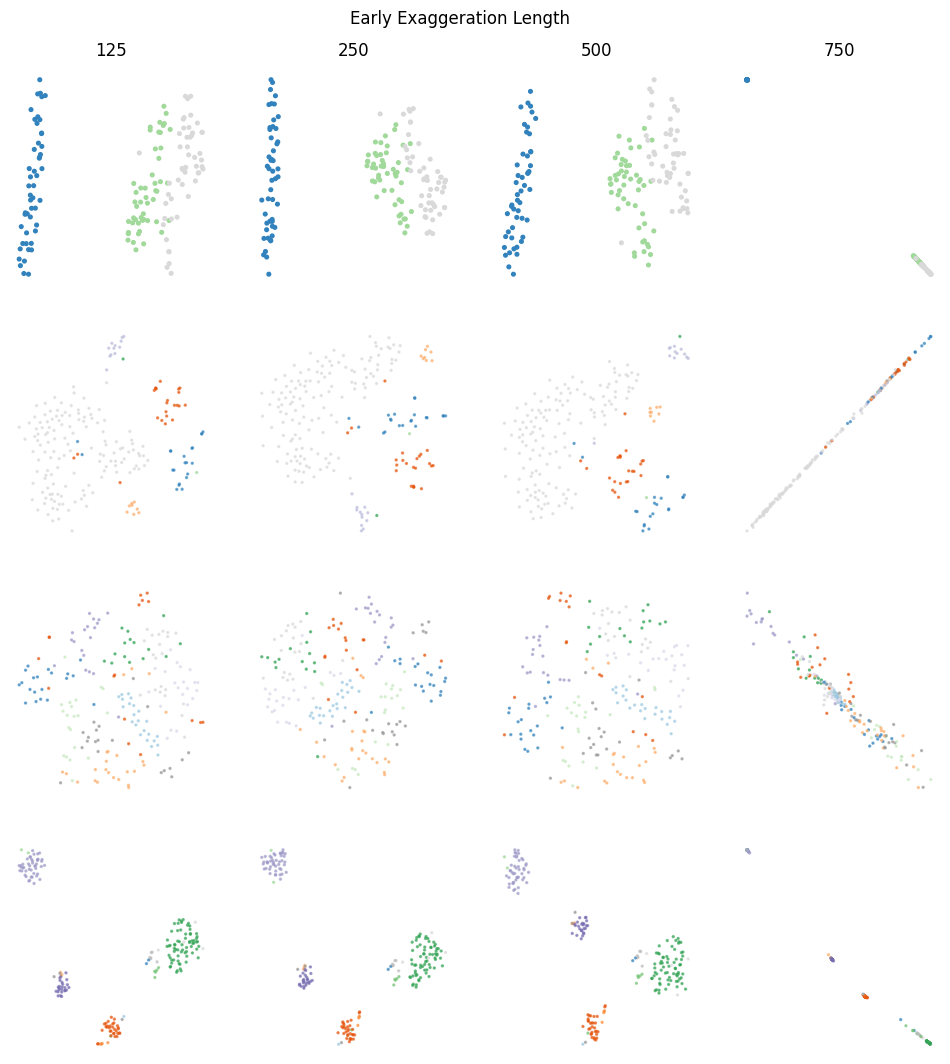

In [116]:
plot_embedding_grid(embeddings_dict, row_parameter=[0,1,2,3], column_parameter=ee_lengths, row_string="", column_string="Early Exaggeration Length", cmap="tab20c")

### Measuring Quality

In [117]:
quality_results = quality_measures.compute_quality_results(embeddings_dict, all_data)

In [118]:
dataset_names = {0: "Iris", 1: "Macosko", 2: "MNIST", 3: "Flow"}

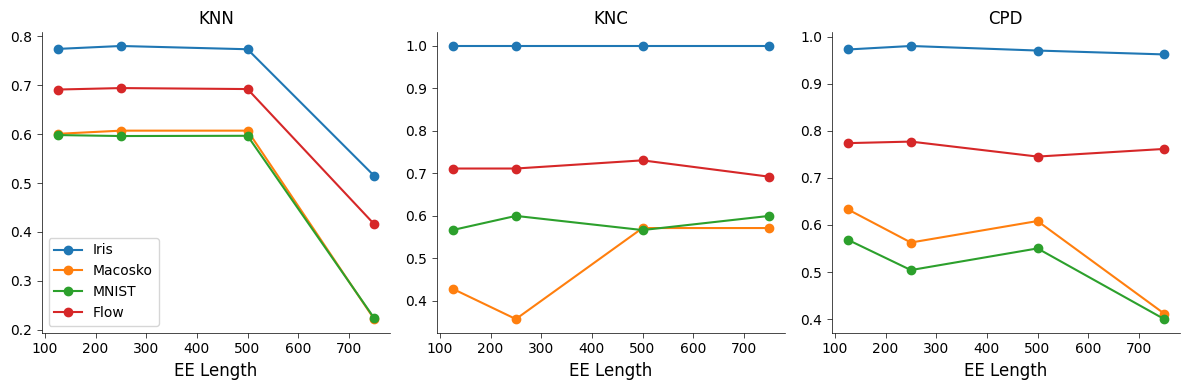

In [119]:
plot_quality_measures(quality_results, dataset_names, "ee_length", x_axis_label="EE Length")

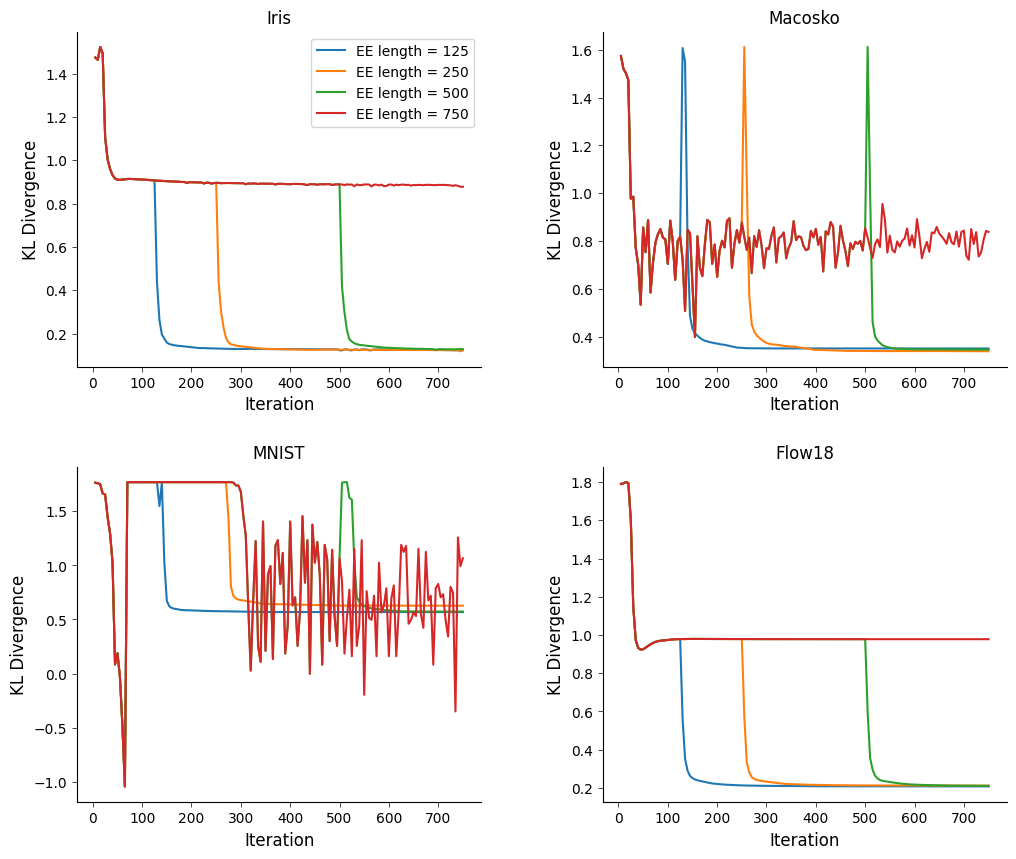

In [120]:
plot_kl_divergences_grid(embeddings_dict, "ee_length")

### Second Experiment: Different Seeds

on MNIST, we try out 4 different seeds and look what happens

In [ ]:
# only mnist 
mnist = datasets.load_mnist()
data, labels = mnist

In [ ]:
#n_points = 50
#mnist = datasets.load_n_samples(n_points, data, labels)

In [166]:
seeds = [1, 12, 42, 100]

In [167]:
embedding_seeds = run_tsne_with_seeds(mnist, ee_lengths, seeds=seeds)

  0%|          | 0/4 [00:00<?, ?it/s]Perplexity value 30 is too high. Using perplexity 16.33 instead


running 125 EE iteration and 625 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 125 EE iteration and 625 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 125 EE iteration and 625 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 125 EE iteration and 625 normal ones


 25%|██▌       | 1/4 [00:07<00:21,  7.06s/it]Perplexity value 30 is too high. Using perplexity 16.33 instead


running 250 EE iteration and 500 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 250 EE iteration and 500 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 250 EE iteration and 500 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 250 EE iteration and 500 normal ones


 50%|█████     | 2/4 [00:16<00:17,  8.61s/it]Perplexity value 30 is too high. Using perplexity 16.33 instead


running 500 EE iteration and 250 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 500 EE iteration and 250 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 500 EE iteration and 250 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 500 EE iteration and 250 normal ones


 75%|███████▌  | 3/4 [00:20<00:06,  6.57s/it]Perplexity value 30 is too high. Using perplexity 16.33 instead


running 750 EE iteration and 0 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 750 EE iteration and 0 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 750 EE iteration and 0 normal ones


Perplexity value 30 is too high. Using perplexity 16.33 instead


running 750 EE iteration and 0 normal ones


100%|██████████| 4/4 [00:23<00:00,  5.92s/it]


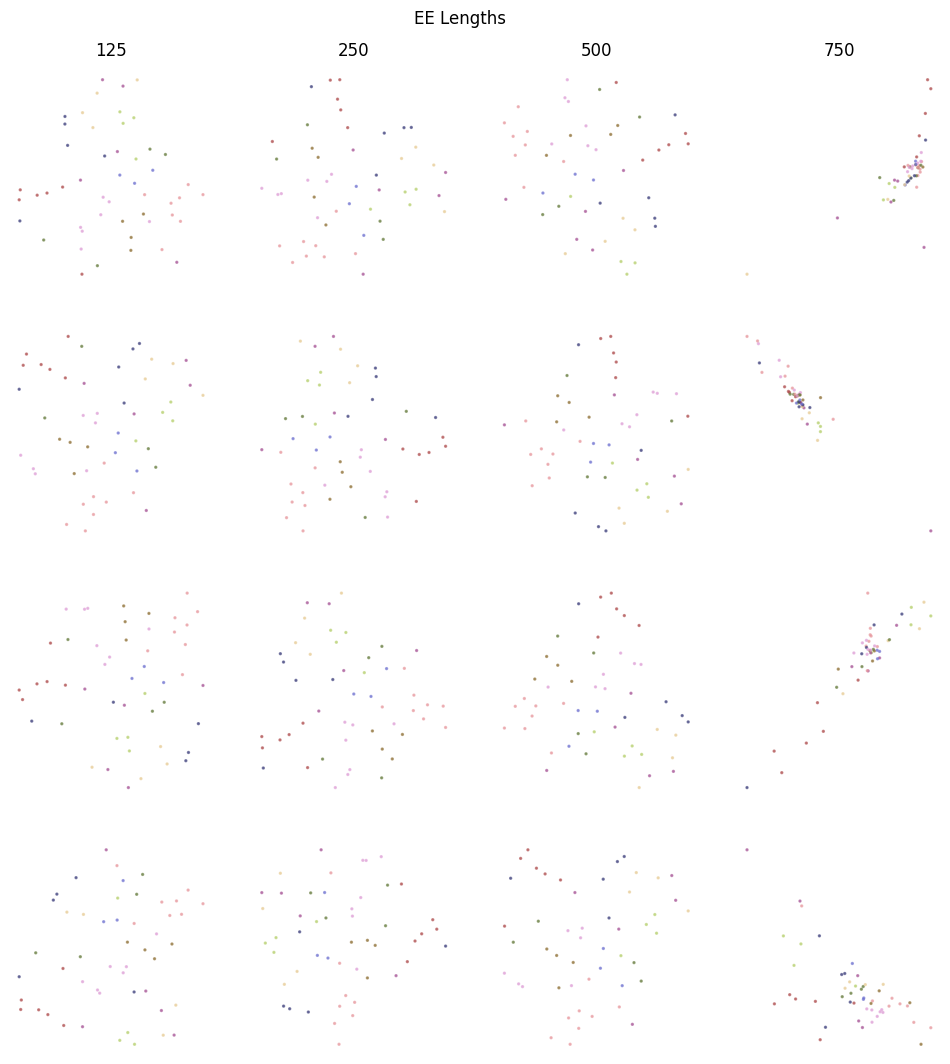

In [168]:
plot_embedding_grid(embedding_seeds, seeds, ee_lengths, column_string="EE Lengths", cmap="tab20b", file_start="ee_length_seeds", emph_first_row=False)

In [170]:
X, y = mnist
quality_results_seeds = average_quality_measures(embedding_seeds, X, ee_lengths)

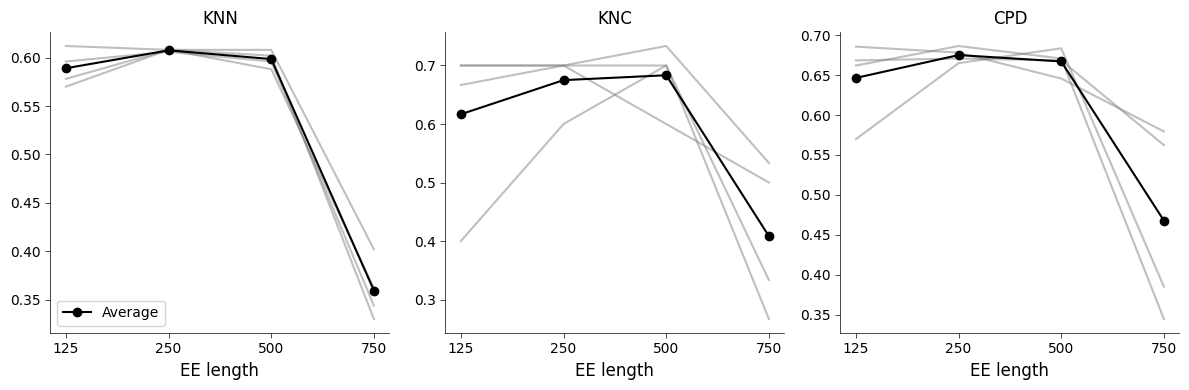

In [173]:
plot_quality_measures_seeds(quality_results_seeds)